# Exercise 1: Performing multiple independent MD simulations in parallel

## Instructor/Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

If you're interested, check my personal website for more future posts/tutorials about advanced sampling methods!

## 1. Running simulations in parallel

In this exercise, the goal is to run 4 indepedent standard NPT MD simulations of the NaCl system in parallel, each for 500 ps. This can be achieved by using the `-multidir` flag in the GROMACS `mdrun` command, which runs multiple simulations simultaneously in different folders. This exercise should be performed in an interactive session on Bridges-2, with 32 cores requested. 

In [1]:
%%bash
# Delete folders sim_*, if there is any. This is not necessary but convenient for rerunning the notebook. 
if ls -d sim_* >/dev/null 2>&1; then
  rm -rf sim_*
fi

To get started, we execute the following commands to set up the example.

In [2]:
%%bash
module load gromacs-mpi/2022.2-gcc11.3.0-openmpi4.1.4-hwloc2.8.0-b2rm openmpi/4.1.1-gcc8.3.1

n=4  # number of simulations
for i in {1..4}
do
    mkdir sim_${i} && cd sim_${i} && cp ../../Inputs/NaCl/* .   # create a folder and copy over gro, top and mdp files
    mpirun -np 1 gmx_mpi grompp -f MD-NPT.mdp -c NaCl.gro -p NaCl.top -o NaCl_md.tpr -maxwarn 1 && cd ../  # Generate the tpr
done

Setting the LD random seed to -4217093

Generated 330891 of the 330891 non-bonded parameter combinations

Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -1751130827

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.152 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun

-------------------------------------------------------------------------------
There are messages associated with the following module(s):
-------------------------------------------------------------------------------

cuda/11.1.1:
   Warning - This module has been deprecated and is scheduled for removal.
   Please transition to a module from the production pool instead.


gcc/11.3.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


gromacs-mpi/2022.2-gcc11.3.0-openmpi4.1.4-hwloc2.8.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


hwloc/2.8.0-gcc11.3.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


openblas/0.

- **Step 1**: Create 4 folders: `sim_1`, `sim_2`, `sim_3`, and `sim_4`.
- **Step 2**: For each folder, copy over the input files, including `NaCl.gro`, `NaCl.top`, and `NPT-MD.mdp`.
- **Step 3**: In each folder, run the GROMACS `grompp` command in the folder to generate the input `tpr` file.

After setting up the simulation inputs, we can run the GROMACS `mdrun` command. Note that the `mdrun` command should be executed one level above the `sim_*` directories (which is the working directory for each cell in this notebook).

In [5]:
%%time
%%bash
module load gromacs-mpi/2022.2-gcc11.3.0-openmpi4.1.4-hwloc2.8.0-b2rm openmpi/4.1.1-gcc8.3.1

mpirun -np 1 gmx_mpi mdrun -s NaCl_md.tpr -deffnm output -multidir sim_1 sim_2 sim_3 sim_4 -ntomp 1

-------------------------------------------------------------------------------
There are messages associated with the following module(s):
-------------------------------------------------------------------------------

cuda/11.1.1:
   Warning - This module has been deprecated and is scheduled for removal.
   Please transition to a module from the production pool instead.


gcc/11.3.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


gromacs-mpi/2022.2-gcc11.3.0-openmpi4.1.4-hwloc2.8.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


hwloc/2.8.0-gcc11.3.0-b2rm:
   Warning - Please note that you are using a preproduction module provided
   for testing purposes. Please report any issues to PSC User Services at
   help@psc.edu.


openblas/0.

CalledProcessError: Command 'b'module load gromacs-mpi/2022.2-gcc11.3.0-openmpi4.1.4-hwloc2.8.0-b2rm openmpi/4.1.1-gcc8.3.1\n\nmpirun -np 1 gmx_mpi mdrun -s NaCl_md.tpr -deffnm output -multidir sim_1 sim_2 sim_3 sim_4 -ntomp 1\n'' returned non-zero exit status 1.

- `-np` specifies the number of MPI processes to run the 4 simulations and has to be a multiple of 4.
- `-ntomp` specifies the number of OpenMP threads per MPI process. Generally, each OpenMP thread uses a CPU core.

In this example, we ran the simulations with 8 MPI processes (`-np 8`), each with 2 OpenMP threads per MPI process (`-ntomp 2`). This means: 

- Each of the 4 simulations was performed with 2 MPI processes, and the workload (e.g. the calculation of interactions) of running a simulation was further divided by 2 threads. 

- A total of 16 CPU cores were used to run the 4 simulations.

- That is, 16 CPU cores were idle during the simulation, so we could have only requested 16 cores when launching the interactive session by using `--ntasks-per-node=16`. (Here we requested 32 cores just for the scaling test in the next section.) 

As can be checked, now we have simulation outputs in each `sim_*` folder.

## 2. CPU scaling: Now, it's your turn! 👨‍💻

In the example above, we used 8 MPI processes (denoted as `np`), with 2 OpenMP threads per MPI process (denoted as `ntomp`), to run 4 simulations in parrallel. To determine a more efficient/cost-effective way to allocate comptuational resources for running MD simulations, it is common to perform a scaling test. This involves timing several short simulations with varying values of `np` or `ntomp`. By plotting the performance, such as ns/day (as demonstrated in the bottom of the log file), against `np` or `ntomp`, we can determine the cutoff point where the performance becomes sublinear.

As an exercise, try running 4 simulations of NaCl in parallel using 4 different values of `ntomp`, including 1, 2, 4, and 8, while keeping `np` fixed at 4. Then, plot the performance as a function of the **the number of cores** and answer the following question: **What is the optimal number of OpenMP threads per MPI process required to run 4 standard MD simulations for the NaCl system with 4 MPI processes?**

To extract the performance of a simulation from its log file, you may find the following function useful.

In [4]:
def get_performance(log):
    with open(log, 'r') as f:
        lines = f.readlines()
    for l in lines:
        if 'Performance' in l:
            return float(l.split()[1])

    print('Simulation not finished.')

In [5]:
%%time
%%bash
module load gromacs/2020.2-cpu openmpi/4.0.5-gcc10.2.0

ntomp=(1 2 4 8)  # 8 is the maximum since we have 128 cores and we fix np at 4
for i in "${ntomp[@]}"
do
    mpirun -np 4 gmx_mpi mdrun -s NaCl_md -deffnm output_$i -multidir sim_1 sim_2 sim_3 sim_4 -ntomp $i
done

                  :-) GROMACS - gmx mdrun, 2020.2-MODIFIED (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
 

 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2019, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technolog

CPU times: user 186 ms, sys: 28.5 ms, total: 215 ms
Wall time: 2min 21s


As shown above, we tried running the simulations using 1, 2, 4, and 8 OpenMP threads per MPI process. From the bottom of each log file, we can get the performance in ns/day for each case, which we can plot below. (Note that the result may vary for different runs, especially for a such small system. However, for larger systems (which are more common), there should be a kink point beyond which the performance becomes sublinear.) 

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Just some settings for plotting
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

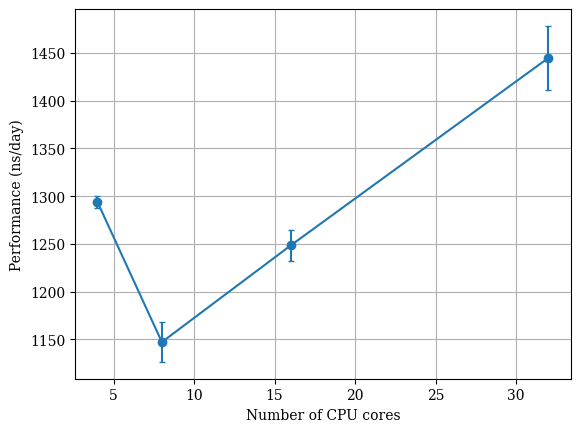

In [7]:
import numpy as np
n_mpi = 4
ntomp = np.array([1, 2, 4, 8])
p_avg, p_std = [], []
for i in ntomp:
    p_list = []
    for j in range(1, 5):  # from sim_1 to sim_4
        p_list.append(get_performance(f'sim_{j}/output_{i}.log'))
    p_avg.append(np.mean(p_list))
    p_std.append(np.std(p_list))

plt.figure()
plt.errorbar(ntomp * n_mpi, p_avg, yerr=p_std, marker='o', capsize=2)
plt.xlabel('Number of CPU cores')
plt.ylabel('Performance (ns/day)')
plt.grid()

The result we see above might not be ideal since the system is very small. But generally for larger systems, what one should see is a linear region where the performance is strictly increasing with the comptuational resources and becomes sublinear after a kink point. Although the scaling test for this system might not show the trend, hopefully you get the idea of how to allocate computational resources in a more cost-effective way!

Note that
- We could have requested 128 cores to test a wider range of the number of cores. Here we requested only 32 cores considering available computing resources for the workshop.
- The optimal number of `np`/`ntomp` for running MD simulations may vary depending on the system being studied and the simulation method used. Therefore, it is generally good practice to conduct a scaling test when kicking off a new proejct.

## Takeaways

- GROMACS simulations can be performed in parallel using the `-multidir` option.

- Run a scaling test for your systems/simulation methods if you plan to spend a lot ouf computational resources on them!